<a href="https://colab.research.google.com/github/PavanReddy28/Supervised-ML/blob/main/Feedforward_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feedforward Neural Network

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.notebook import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [3]:
class SigmoidNeuron:

  def __init__(self):
    self.w = None
    self.b = None
  
  def perceptron(self, X):
    return np.dot(X, self.w.T) + self.b
  
  def sigmoid(self, X):
    return 1.0 / (1.0 + np.exp(-X))

  def grad_w(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)

  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")

  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, loss_fn="mse", display_loss=False):
    
    #intialize
    if initialize:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
    
    if display_loss:
      loss={}

    for i in tqdm(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        dw += self.grad_w(x,y)
        db += self.grad_b(x,y)

      m = X.shape[1]
      self.w -= learning_rate * dw/m
      self.b -= learning_rate * db/m

      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(list(loss.values()))
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()


  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [4]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

## Data Preprocessing

In [5]:
data, labels = make_blobs(1000, 2, 4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


[]

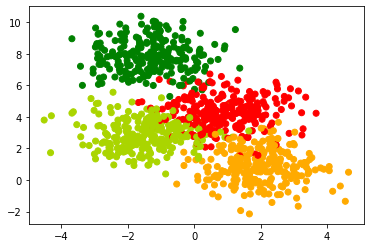

In [6]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.plot()

In [7]:
# Before doing multi-class classification, we want to do a binary classification.
labels_orig = labels
labels = np.mod(labels_orig, 2)

[]

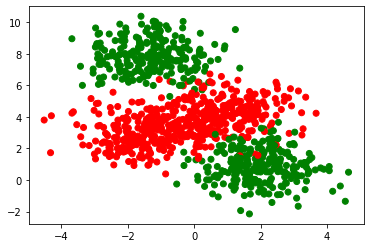

In [8]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.plot()

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, Y_val.shape)

(750, 2) (250,)


## Train - SN

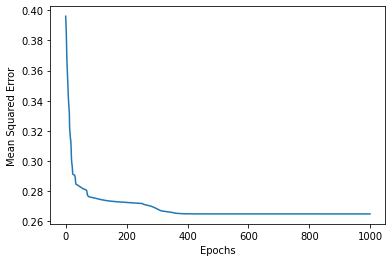

In [10]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=0.5, display_loss = True)

In [11]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarized_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = sn.predict(X_val)
Y_pred_binarized_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_train, Y_pred_binarized_train)
accuracy_val = accuracy_score(Y_val, Y_pred_binarized_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.73
Validation accuracy 0.72


In [12]:
X_train.shape

(750, 2)

[]

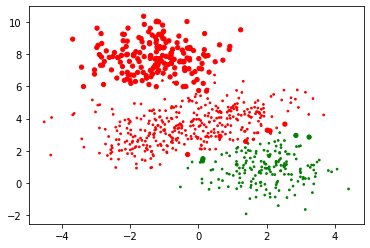

In [13]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarized_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarized_train-Y_train)+0.2))
plt.plot()

## Feedforward Network

In [14]:
class FFSNNetwork:

  def __init__(self, n_inputs, n_outputs, hidden_sizes=[2]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
    
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)

    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    
    return self.H[self.nh+1]

  def grad_sigmoid(self, x):
    return x*(1-x) 

  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss = False):

    # initialize w, b
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))

    if display_loss:
      loss = {}
    
    for e in tqdm(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))

      for x, y in zip(X, Y):
        self.grad(x,y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
      
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1]
        self.B[i+1] -= learning_rate * dB[i+1]

      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y, Y_pred)

    if display_loss:
      plt.plot(list(loss.values()))
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()

  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()


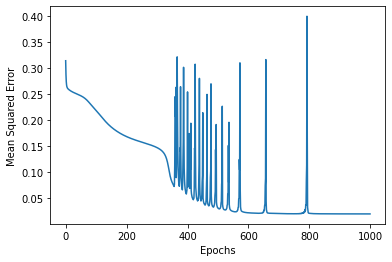

In [15]:
ffsn = FFSNNetwork(2, 1, [2,3])
ffsn.fit(X_train, Y_train, epochs=1000, learning_rate=0.001, initialize= True, display_loss = True)

In [16]:
Y_pred_train = ffsn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = ffsn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.98
Validation accuracy 0.94


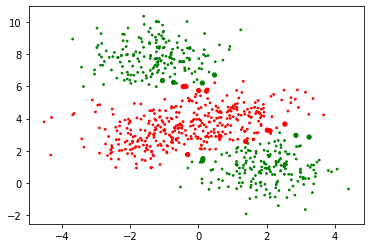

In [17]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()